## Telecom Churn Case Study:

## Problem Statement:
In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

## Steps:
- In this project below steps are followed:
  1. Data understanding, preparation & pre-processing
  2. EDA
  3. Model Selection, Model Building, Model Evaluation
  4. Final Model Evaluation with Kaggle Test Data
  5. Business Insights & Recommendations

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,KFold,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import precision_score,recall_score
from imblearn.metrics import specificity_score


### Utility API's:
- Below Utilitiy API's are defined for code reusability.

In [2]:
#Find Missing Value percentage, and round of the value to 3 decimal values
def get_missing_value_percentage(X):
  percent_missing = round((X.isnull().sum() / X.isnull().count()*100),3).to_frame('missing_percentage').sort_values('missing_percentage',ascending = False)
  return percent_missing

In [3]:
#Check for NULL values
# if the % of NULL values is > 50%, then Remove the NULL values from the data, as these values might not help in further analysis
def find_na_value_percentage(df: pd.DataFrame,percentage):
    if telecom_churn_data.isnull().sum().sum() != 0:
      percentage_value = (telecom_churn_data.isnull().sum() / len(df)) * 100
      na_value_data = (telecom_churn_data.isnull().sum() / len(df)) * 100
      na_value_data = na_value_data.drop(na_value_data[na_value_data == 0].index).sort_values(ascending=False)
      missing_value_data = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percentage_value})

      missing_data_condition = missing_value_data[(missing_value_data['percent_missing']<=percentage) ].index
      missing_value_data = missing_value_data.drop(missing_data_condition)
      return missing_value_data

In [4]:
#Utility to plot different features
def plot_sns_boxplot(col_name_prefix):
  plt.figure(figsize=(20,15))
  plt.subplot(2,3,1)
  sns.boxplot(data=telecom_churn_data, y=col_name_prefix+"_6",x="churn_probability",hue="churn_probability",showfliers=False,)
  plt.subplot(2,3,2)
  sns.boxplot(data=telecom_churn_data, y=col_name_prefix+"_7",x="churn_probability",hue="churn_probability",showfliers=False,)
  plt.subplot(2,3,3)
  sns.boxplot(data=telecom_churn_data, y=col_name_prefix+"_8",x="churn_probability",hue="churn_probability",showfliers=False,)
  plt.show()

In [5]:
#Utilitiy to calculate the accuracy, scores based on provided actual, predicted data
def calculate_metrics(actual_data,pred_data):
  accuracy = accuracy_score(actual_data, pred_data)
  precision = precision_score(actual_data,pred_data)
  recall = recall_score(actual_data,pred_data)
  specificity = specificity_score(actual_data,pred_data)
  return [accuracy,precision,recall,specificity]


In [6]:
def print_metrics(prefix,metrics):
  print(prefix,"- Data Metrics:")
  print("=====================================================")
  print("#####################################################")
  print("Accuracy %:",round(100*metrics[0],2))
  print("Precision %:",round(100*metrics[1],2))
  print("Recall / Sensitivity %:",round(100*metrics[2],2))
  print("Specificity %:",round(100*metrics[3],2))
  print("#####################################################")
  print("=====================================================")

In [7]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
def calculate_vif(X_train,column_list):
    vif = pd.DataFrame()
    vif['Features'] = X_train[column_list].columns
    vif['VIF'] = [variance_inflation_factor(X_train[column_list].values, i) for i in range(X_train[column_list].shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [8]:
def fit_logitreg_statsmodel(X_train,y_train,column_list):
    X_train_sm = sm.add_constant(X_train[column_list])

    #Instantiate the model
    logit_reg = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial())

    # Fit the model
    logit_reg = logit_reg.fit()
    return X_train_sm, logit_reg

# 1. Data understanding, preparation & pre-processing

In [9]:
# Reading the training dataset
telecom_churn_data_original = pd.read_csv("train.csv")
#Copying the original data
telecom_churn_data = telecom_churn_data_original.copy()
telecom_churn_data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [10]:
#Check the dataframe shape
telecom_churn_data.shape

(69999, 172)

In [11]:
#Check the parameters
telecom_churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 91.9+ MB


In [12]:
#Analyse the data with help of sweetviz to get more understanding on the data
#!pip install sweetviz
#import sweetviz as sv

#telecom_sweet_report = sv.analyze(telecom_churn_data)
#telecom_sweet_report.show_html('telecom_churn_sweetviz_report.html')

- As per the Sweetviz visualization report, there are some of the columns which has only 1 distinct value

In [13]:
print(telecom_churn_data.sort_values(by=['id']).nunique().head(15))

id                      69999
circle_id                   1
loc_og_t2o_mou              1
std_og_t2o_mou              1
loc_ic_t2o_mou              1
last_date_of_month_6        1
last_date_of_month_7        1
last_date_of_month_8        1
arpu_6                  61615
arpu_7                  61425
arpu_8                  60194
onnet_mou_6             20057
onnet_mou_7             20076
onnet_mou_8             19725
offnet_mou_6            26254
dtype: int64


#### Dropping columns with unique / single value:
- As per the data provided  the features like last_date_of_month is not changing for each month, and it has no direct impact on the data. So dropping the columns with unique entry, from above output.

In [14]:
#Drop Unique Columns
unique_value_columns = ["circle_id","loc_og_t2o_mou","std_og_t2o_mou",
                        "loc_ic_t2o_mou","last_date_of_month_6",
                        "last_date_of_month_7","last_date_of_month_8"]
telecom_churn_data = telecom_churn_data.drop(unique_value_columns,axis=1)

In [15]:
telecom_churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 165 entries, id to churn_probability
dtypes: float64(132), int64(27), object(6)
memory usage: 88.1+ MB


In [16]:
#Drop 'id' column as it will not  impact the final outcome
telecom_churn_data = telecom_churn_data.drop('id',axis=1)

In [17]:
# List only the numeric columns
obj_cols = telecom_churn_data.select_dtypes(include=['object']).columns
print(obj_cols)

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8'],
      dtype='object')


In [18]:
#Check the stats
telecom_churn_data.describe()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,...,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
mean,283.134365,278.185912,278.858826,133.153275,133.894438,132.978257,198.874771,197.153383,196.543577,9.765435,...,0.081444,0.085487,0.916325,0.909544,0.890319,1220.639709,68.108597,65.935830,60.07674,0.101887
std,334.213918,344.366927,351.924315,299.963093,311.277193,311.896596,316.818355,322.482226,324.089234,57.374429,...,0.634547,0.680035,0.276907,0.286842,0.312501,952.426321,269.328659,267.899034,257.22681,0.302502
min,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,93.581000,86.714000,84.095000,7.410000,6.675000,6.410000,34.860000,32.240000,31.575000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,197.484000,191.588000,192.234000,34.110000,32.280000,32.100000,96.480000,91.885000,91.800000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,370.791000,365.369500,369.909000,119.390000,115.837500,115.060000,232.990000,227.630000,229.345000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1813.000000,0.000000,0.000000,0.00000,0.000000
max,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,10752.560000,8362.360000,7043.980000,14007.340000,2850.980000,...,33.000000,41.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.21000,1.000000


## 1.1. Missing Value Handling

### 1.1.A. Identifying Missing Values

- Check at the missing values for each column

In [19]:
#Check Missing value percentage
percent_missing = get_missing_value_percentage(telecom_churn_data)
percent_missing.head(30)

,missing_percentage
arpu_3g_6,74.902
av_rech_amt_data_6,74.902
fb_user_6,74.902
date_of_last_rech_data_6,74.902
max_rech_data_6,74.902
count_rech_2g_6,74.902
count_rech_3g_6,74.902
total_rech_data_6,74.902
night_pck_user_6,74.902
arpu_2g_6,74.902


- From the above data, some of the columns where there are more than 50% missing values are of useful information about recharge, and information about the category of users (like FB Users, Users with specific prepaid schemes related to night package etc.), dropping these columns might impact the outcome of the model. So logic is added to impute the numerical, categocical columns, as explained below.

In [20]:
missing_data = find_na_value_percentage(telecom_churn_data,70.00)
missing_column_list_50p = missing_data['column_name'].tolist()

In [21]:
missing_column_list_50p

['date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8']

- As per the data distribution, coloumns related to night_pck_user, and fb_user are categorical columns, as they indicate where user using those services are not. So for such categorical columns imputing the values with '-1' (which can be treated as different category).

In [22]:
#Removing other date columns
telecom_churn_data = telecom_churn_data.drop(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'],axis=1)

### 1.1.B. Data Imputations

In [23]:
categorical_na_cols =  ['night_pck_user_6','night_pck_user_7','night_pck_user_8',
             'fb_user_6','fb_user_7','fb_user_8']

In [24]:
# replace missing values with '-1'
telecom_churn_data[categorical_na_cols] = telecom_churn_data[categorical_na_cols].apply(lambda x: x.fillna(-1))

In [25]:
# Other columns  are related to recharge and are numberical columns
# For such numerical columns where values are missing, impute value as 0
# Not considering count variables (count_rech_2g, count_rech_3g), as there is data about the revenue for the same
numerical_na_cols = ['total_rech_data_6','total_rech_data_7','total_rech_data_8',
                  'max_rech_data_6','max_rech_data_7','max_rech_data_8',
                  'av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8',
                  'arpu_3g_6','arpu_3g_7','arpu_3g_8',
                  'arpu_2g_6','arpu_2g_7','arpu_2g_8']

- As there are missing values for the recharge amount which are of numerical columns, impute 0's to all numerical columns

In [26]:
telecom_churn_data[numerical_na_cols] = telecom_churn_data[numerical_na_cols].apply(lambda x: x.fillna(0))

In [27]:
telecom_churn_data.shape

(69999, 161)

In [28]:
#Re-Check Missing value percentage after imputing numerical, categorical columns
percent_missing = get_missing_value_percentage(telecom_churn_data)
percent_missing.head(30)

,missing_percentage
count_rech_2g_6,74.902
count_rech_3g_6,74.902
date_of_last_rech_data_6,74.902
count_rech_3g_7,74.478
date_of_last_rech_data_7,74.478
count_rech_2g_7,74.478
count_rech_3g_8,73.690
date_of_last_rech_data_8,73.690
count_rech_2g_8,73.690
std_ic_t2o_mou_8,5.290


In [29]:
missing_data = find_na_value_percentage(telecom_churn_data,70.00)
missing_column_list_70p = missing_data['column_name'].tolist()
missing_column_list_70p

['date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8']

In [30]:
#Drop the above columsn which has higher missing values
telecom_churn_data = telecom_churn_data.drop(missing_column_list_70p,axis=1)

In [31]:
# Check the updated columns size
telecom_churn_data.shape

(69999, 152)

In [32]:
missing_data = find_na_value_percentage(telecom_churn_data,00.01)
missing_column_list = missing_data['column_name'].tolist()
missing_column_list

['onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou

In [33]:
#Re-Check Missing value percentage after imputing numerical, categorical columns
percent_missing = get_missing_value_percentage(telecom_churn_data)
percent_missing.head(30)

,missing_percentage
loc_ic_t2t_mou_8,5.290
loc_og_t2m_mou_8,5.290
loc_og_t2c_mou_8,5.290
std_ic_mou_8,5.290
loc_og_mou_8,5.290
std_og_t2t_mou_8,5.290
std_og_t2m_mou_8,5.290
std_ic_t2o_mou_8,5.290
std_og_t2f_mou_8,5.290
std_og_t2c_mou_8,5.290


In [34]:
telecom_churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 152 entries, arpu_6 to churn_probability
dtypes: float64(126), int64(26)
memory usage: 81.2 MB


In [35]:
#using simple imputer for imputation
#As per above only numerical columns are remaining, so using mean as the strategy
#This will be applied in numerical columns 
imputer = SimpleImputer(missing_values = np.nan,strategy ='mean')
imputer = imputer.fit(telecom_churn_data)
#Impute the data    
imputed_data = imputer.transform(telecom_churn_data)

telecom_churn_data = pd.DataFrame(imputed_data, columns=telecom_churn_data.columns)
telecom_churn_data.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,...,0.0,0.0,-1.0,-1.0,-1.0,1958.0,0.0,0.0,0.0,0.0
1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,...,0.0,0.0,-1.0,1.0,-1.0,710.0,0.0,0.0,0.0,0.0
2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,0.00,...,0.0,0.0,-1.0,-1.0,-1.0,882.0,0.0,0.0,0.0,0.0
3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,0.00,...,0.0,0.0,-1.0,-1.0,-1.0,982.0,0.0,0.0,0.0,0.0
4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,53.64,...,1.0,0.0,1.0,1.0,1.0,647.0,0.0,0.0,0.0,0.0


In [36]:
#Re-Check Missing value percentage after imputing all remaining columns
percent_missing = get_missing_value_percentage(telecom_churn_data)
percent_missing.head(30)

,missing_percentage
arpu_6,0.0
max_rech_amt_8,0.0
total_rech_num_7,0.0
total_rech_num_8,0.0
total_rech_amt_6,0.0
total_rech_amt_7,0.0
total_rech_amt_8,0.0
max_rech_amt_6,0.0
max_rech_amt_7,0.0
last_day_rch_amt_6,0.0


- After doing the cleanup, and missing value imputations, there are 155 features present in dataset.

##  1.2. Highly Profitable Customers / High Value Customers:
As one one the primary goals of the assignment is to retain highly profitable customers, so the following critetia is defined  for finding the highly valued customers:
Considering calls (actual recharge amount) + data (av recharge )for all 3 months (June, July, August),where  customers with recharge amount months is more than the over all average (50%). For this the threshold is taken as 75%. 
So customers with 75% or above are treated as High-Value customers

In [37]:
#Calclulating the average recharge
telecom_churn_data['av_rech_amt_6_7_8'] = (telecom_churn_data['total_rech_amt_6'] + telecom_churn_data['total_rech_amt_7'] + telecom_churn_data['total_rech_amt_8'])/3

In [38]:
#Calclulating the average recharge for data
# Take the number of recharges, and the average
telecom_churn_data['av_rech_data_amt_6_7_8'] = ((telecom_churn_data['av_rech_amt_data_6']*telecom_churn_data['av_rech_amt_data_6']) + (telecom_churn_data['av_rech_amt_data_7']*telecom_churn_data['av_rech_amt_data_7']) + (telecom_churn_data['av_rech_amt_data_8']*telecom_churn_data['av_rech_amt_data_8']))/3

In [39]:
#Overall average is average of above 2
telecom_churn_data['final_av_rech_amt_6_7_8'] = (telecom_churn_data['av_rech_amt_6_7_8'] + telecom_churn_data['av_rech_data_amt_6_7_8'])/2

In [40]:
#Calculate  75%
avg_df = telecom_churn_data['final_av_rech_amt_6_7_8'].quantile(0.75)
avg_df

3866.333333333333

In [41]:
#Find the high value customer data
telecom_churn_data_filtered = telecom_churn_data[telecom_churn_data['final_av_rech_amt_6_7_8'] >= avg_df]
telecom_churn_data_filtered.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,av_rech_amt_6_7_8,av_rech_data_amt_6_7_8,final_av_rech_amt_6_7_8
4,240.708,128.191,101.565,21.280000,4.830000,6.13,56.990000,38.110000,9.63,53.640000,...,1.0,1.0,647.0,0.00,0.00,0.00,0.0,182.666667,29090.000000,14636.333333
7,167.861,167.869,167.866,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,...,1.0,1.0,584.0,82.26,73.56,177.14,0.0,198.000000,39204.000000,19701.000000
15,580.549,377.294,338.286,10.430000,24.990000,194.43,317.110000,341.790000,197.09,0.000000,...,-1.0,1.0,602.0,0.00,0.00,0.00,0.0,568.666667,15810.666667,8189.666667
27,390.489,350.985,421.300,8.580000,11.480000,12.68,133.160000,158.730000,182.83,0.000000,...,1.0,1.0,573.0,700.40,185.71,173.72,0.0,462.333333,60079.000000,30270.666667
33,438.077,0.000,213.781,133.153275,133.894438,0.00,198.874771,197.153383,2.68,9.765435,...,-1.0,1.0,457.0,0.00,0.00,0.00,1.0,252.333333,106176.333333,53214.333333


In [42]:
#Check the current size, after filtering high value customers
telecom_churn_data_filtered.shape

(17500, 155)

In [43]:
# Additional variables created for high value customer detection are not needed,
# as data is  already filtered out. So dropping the same
telecom_churn_data_filtered = telecom_churn_data_filtered.drop(['av_rech_amt_6_7_8','av_rech_data_amt_6_7_8','final_av_rech_amt_6_7_8'], axis=1)
telecom_churn_data_filtered.shape

(17500, 152)

## 1.3. Check for Outliers

In [44]:
# Check for the numerical columns
telecom_churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 155 entries, arpu_6 to final_av_rech_amt_6_7_8
dtypes: float64(155)
memory usage: 82.8 MB


In [45]:
# As all the objects are numerical (float64 / int64) types. List only the numeric columns
# Looking at quantiles from 0.90 to 1. 
# Just to be sure, only the relevant colums  are picked up, following criteria is defined:
categorical_cols = ['night_pck_user_6', 'night_pck_user_7','night_pck_user_8',
                    'fb_user_6', 'fb_user_7','fb_user_8']
target_col = ['churn_probability']
numerical_col = [column for column in telecom_churn_data_filtered.columns if column not in (categorical_cols,target_col)]
telecom_churn_numerical = telecom_churn_data_filtered[numerical_col]
telecom_churn_numerical.quantile(np.arange(0.9,1.01,0.01)).style.bar()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0.900000,798.560500,808.507700,819.238300,266.190000,272.444000,263.968000,473.170000,484.594000,473.027000,12.180000,7.014568,7.004892,17.662000,9.842191,9.771783,118.802000,117.631000,118.505000,273.373000,271.990000,273.612000,12.710000,12.460000,12.212000,3.540000,4.332000,4.650000,421.916000,423.433000,415.938000,93.113000,99.567000,93.827000,142.836000,159.943000,141.022000,1.126377,1.084062,1.057739,0.000000,0.000000,0.000000,311.817000,353.285000,323.295000,0.030000,0.000000,0.030000,12.832000,14.680000,15.560000,1.030000,0.000000,0.000000,735.533000,765.733000,748.714000,120.886000,119.483000,118.790000,296.033000,294.462000,296.755000,38.481000,39.780000,37.790000,467.272000,468.785000,467.640000,18.831000,19.330000,19.190000,48.420000,50.992000,49.060000,3.960000,4.390000,4.012000,0.000000,0.000000,0.000000,78.342000,81.633000,80.018000,568.601000,577.452000,580.045000,0.200000,0.033371,0.040392,8.562000,10.415000,10.296000,0.854063,1.019680,0.963214,16.000000,17.000000,16.000000,945.100000,964.000000,967.000000,252.000000,252.000000,252.000000,220.000000,200.000000,239.000000,5.000000,6.000000,6.000000,252.000000,252.000000,252.000000,354.000000,396.000000,397.000000,577.805000,567.740000,560.590000,1296.892000,1367.869000,1416.303000,245.547000,244.703000,255.404000,222.543000,221.370000,224.683000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,4.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2793.200000,755.631000,749.133000,674.254000,0.000000
0.910000,837.449390,844.670730,857.167690,296.739000,302.812700,294.266300,505.371400,517.230500,512.639900,16.534500,7.014568,7.480900,22.944500,9.842191,9.771783,130.243600,128.491800,131.146300,293.652600,289.380500,293.941800,14.180000,13.940900,

- Check for the Percentage changes from 99th percentile:
  - From above bar plot, data, the amount of change is more after 90% higher after 90, and in particular most of the columns has huge change (>200% or so) from 99th percentile. To avoid outliers, considering the 99th percentile as cutoff. 

In [46]:
#Replace the outliers with 99 percentile values
for col in numerical_col:
  cutoff_value = telecom_churn_data_filtered[col].quantile(0.99)
  outlier_condition_check = telecom_churn_data_filtered[col] > cutoff_value
  telecom_churn_data_filtered.loc[outlier_condition_check, col] = cutoff_value
  telecom_churn_numerical.loc[outlier_condition_check, col] = cutoff_value
###

In [47]:
#Re-check if the outliers are taken care of
telecom_churn_numerical.quantile(np.arange(0.9,1.01,0.01)).style.bar()

## 1.4. Dummy Variables:
- As categorical columns are already encoded as -1(for na values), 0, 1, at earlier  step,so we are not doing any explicit dummy variable creation.

## 1.5. Deriving New variables:

In [48]:
telecom_churn_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17500 entries, 4 to 69998
Columns: 152 entries, arpu_6 to churn_probability
dtypes: float64(152)
memory usage: 20.4 MB


In [49]:
# Based on 'aon' (Age On Network) feature, calcuate the age in years
# creating a new variable 'tenure_in_years'
telecom_churn_data_filtered['tenure_in_years'] = (telecom_churn_data_filtered['aon']/365).round(0)

In [50]:
# Reduction in Recharge Amount (Deduct the average recharge amount of 1st 2 months from last month)
telecom_churn_data_filtered['diff_rech_amt'] =  telecom_churn_data_filtered['total_rech_amt_8'] - ((telecom_churn_data_filtered['total_rech_amt_6'] + telecom_churn_data_filtered['total_rech_amt_7'])/2)
telecom_churn_data_filtered['reduction_rech_amt'] = np.where((telecom_churn_data_filtered['diff_rech_amt'] < 0), 1, 0) 

In [51]:
#Reduction in number of recharges (Deduct thetelecom_churn_data_filtered['diff_rech_amt'] =  telecom_churn_data_filtered['total_rech_amt_8'] - ((telecom_churn_data_filtered['total_rech_amt_6'] + telecom_churn_data_filtered['total_rech_amt_7'])/2)
telecom_churn_data_filtered['diff_rech_num'] =  telecom_churn_data_filtered['total_rech_num_8'] - ((telecom_churn_data_filtered['total_rech_num_6'] + telecom_churn_data_filtered['total_rech_num_7'])/2)
telecom_churn_data_filtered['reduction_rech_num'] = np.where((telecom_churn_data_filtered['diff_rech_num'] < 0), 1, 0) 

In [52]:
# Reduction in ARPU (Deduct the average recharge aamount of 1st 2 months from last month)
telecom_churn_data_filtered['diff_arpu'] = telecom_churn_data_filtered['arpu_8'] - ((telecom_churn_data_filtered['arpu_6'] + telecom_churn_data_filtered['arpu_7'])/2)
telecom_churn_data_filtered['reduction_arpu'] = np.where((telecom_churn_data_filtered['diff_arpu'] < 0), 1, 0) 

In [53]:
# Difference in MOU (Cumulative of OG, IC MOU)
telecom_churn_data_filtered['diff_og_mou'] =  telecom_churn_data_filtered['total_og_mou_8'] - ((telecom_churn_data_filtered['total_og_mou_6'] + telecom_churn_data_filtered['total_og_mou_7'])/2)
telecom_churn_data_filtered['reduction_og_mou'] = np.where((telecom_churn_data_filtered['diff_og_mou'] < 0), 1, 0)

telecom_churn_data_filtered['diff_ic_mou'] =  telecom_churn_data_filtered['total_ic_mou_8'] - ((telecom_churn_data_filtered['total_ic_mou_6'] + telecom_churn_data_filtered['total_ic_mou_7'])/2)
telecom_churn_data_filtered['reduction_ic_mou'] = np.where((telecom_churn_data_filtered['diff_og_mou'] < 0), 1, 0) 

# 2. EDA

## 2.1. Univariate Analysis

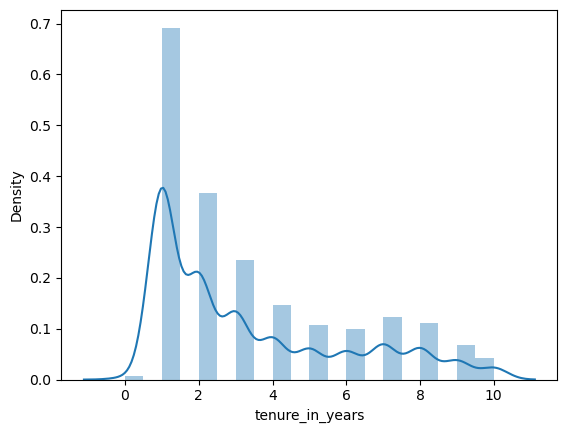

In [54]:
# Checking the impact of tenure_in_years wrto churn_probability
sns.distplot(telecom_churn_data_filtered['tenure_in_years'],bins=20)
plt.show()

Looks the customer density is more in 0-2 years

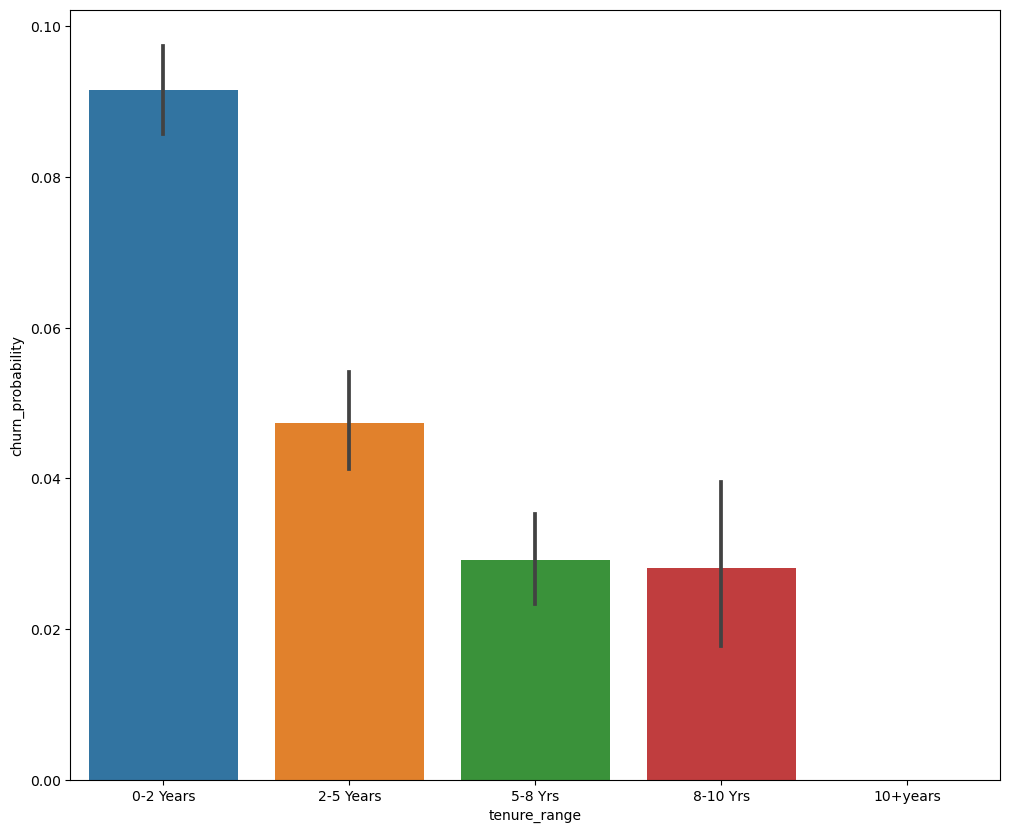

In [55]:
# Plotting a bar plot for tenure of customer in netwrok
tn_range = [0, 2, 5, 8, 10, 11]
tn_label = [ '0-2 Years', '2-5 Years', '5-8 Yrs', '8-10 Yrs', '10+years']
telecom_churn_data_filtered['tenure_range'] = pd.cut(telecom_churn_data_filtered['tenure_in_years'], tn_range, labels=tn_label)
plt.figure(figsize=[12,10])
sns.barplot(x='tenure_range',y='churn_probability', data=telecom_churn_data_filtered)
plt.show()

- From the above plot it is  clear that, there is higher churn for the customers who are for a shorter tenure (<2 years) in network. As the tenure increases, the churn is decreasing.

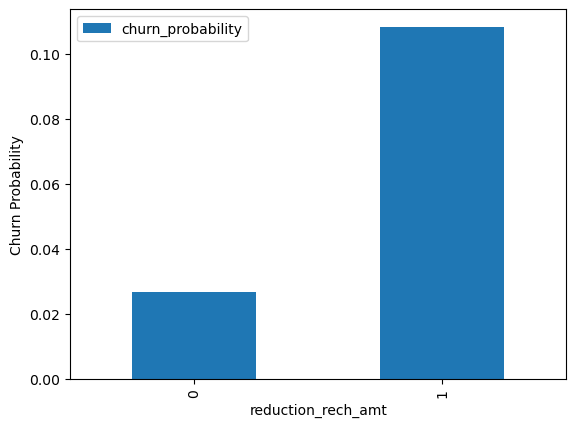

In [56]:
#Plot the reduction in recharge amount
telecom_churn_data_filtered.pivot_table(values='churn_probability', index='reduction_rech_amt', aggfunc='mean').plot.bar()
plt.ylabel('Churn Probability')
plt.show()

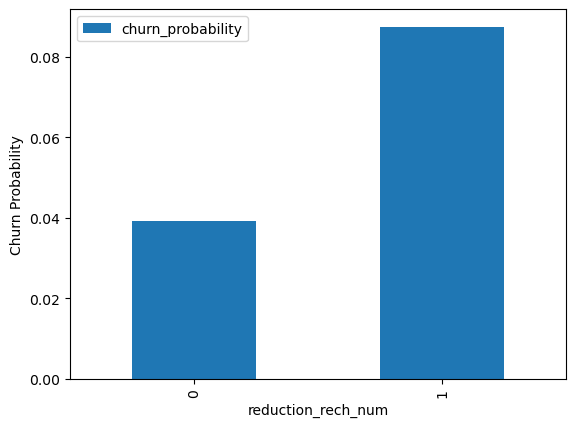

In [57]:
#Plot the reduction in recharge num
telecom_churn_data_filtered.pivot_table(values='churn_probability', index='reduction_rech_num', aggfunc='mean').plot.bar()
plt.ylabel('Churn Probability')
plt.show()

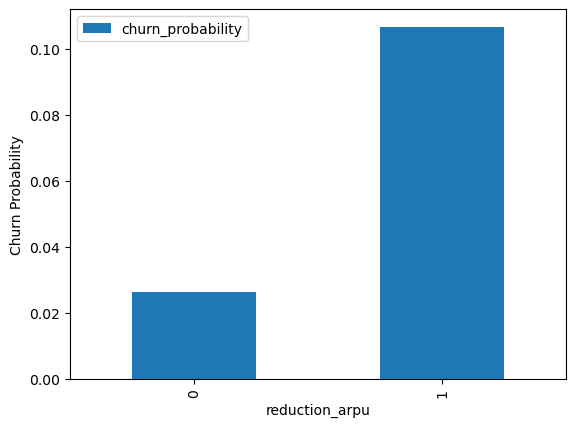

In [58]:
#Plot the reduction in reachrge amount
telecom_churn_data_filtered.pivot_table(values='churn_probability', index='reduction_arpu', aggfunc='mean').plot.bar()
plt.ylabel('Churn Probability')
plt.show()

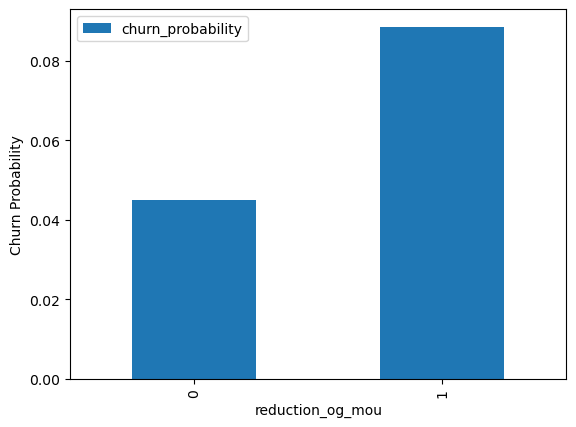

In [59]:
#Plot against reduction in o/g MOU
telecom_churn_data_filtered.pivot_table(values='churn_probability', index='reduction_og_mou', aggfunc='mean').plot.bar()
plt.ylabel('Churn Probability')
plt.show()

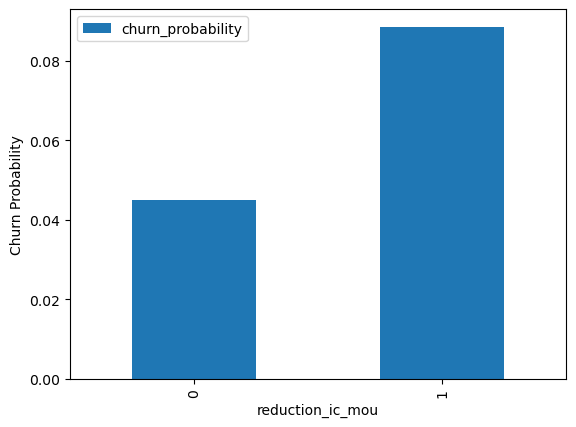

In [60]:
#Plot against reduction in i/c MOU
telecom_churn_data_filtered.pivot_table(values='churn_probability', index='reduction_ic_mou').plot.bar()
plt.ylabel('Churn Probability')
plt.show()

- From the above plots, difference in ARPU, Recharge Amount, and Minutes of Usage for both Outgoing, incoming calls, it is evident that the reduction of these values are higher for churned users.

- Based on last Month (8, August) data, check the pattern of users where the custoemrs have not used any of the services like calls (both incoming , outgoing), internet in the month of August. So this effectively will lead to minial revenue. If the user has not made any of the services (entry is 0 for those columns as per data), then treat those users as churned.  Checking the same via BoxPlot.

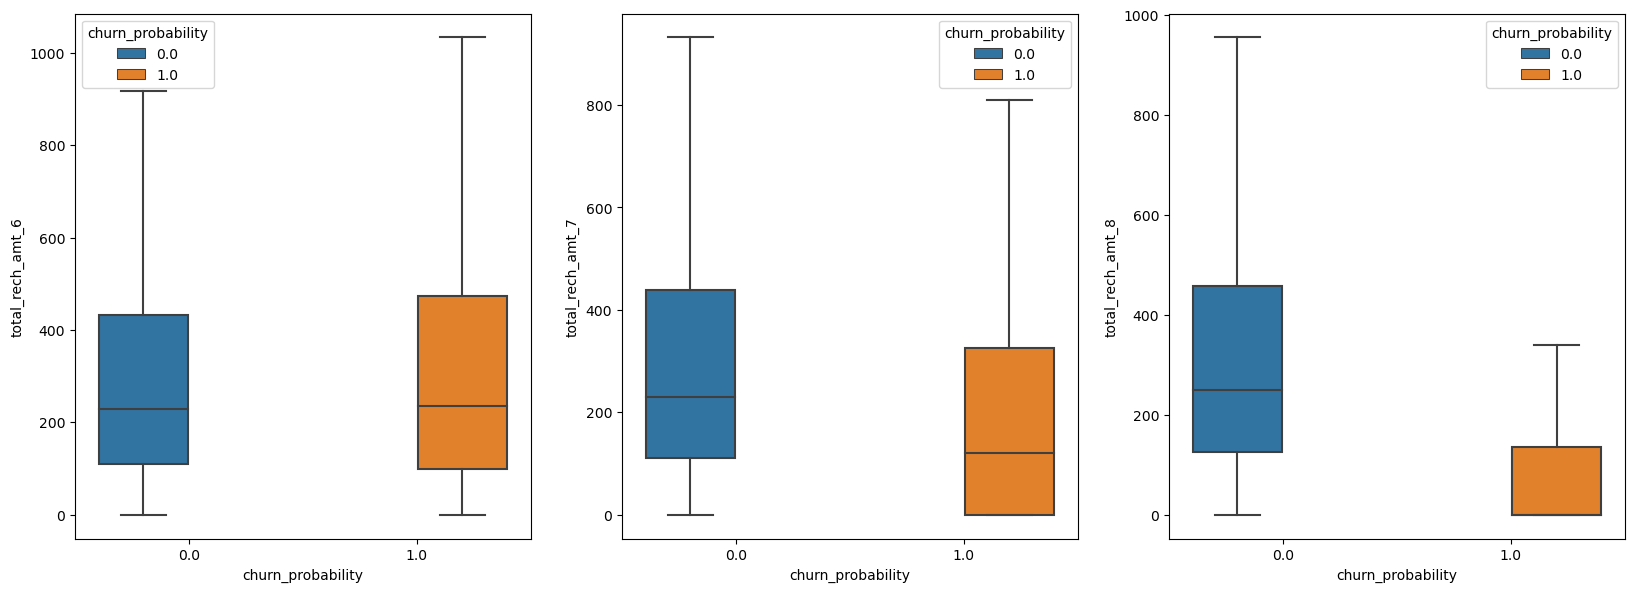

In [61]:
#Draw the box plot to understand the pattern of churn wrto total recharge amount
plot_sns_boxplot("total_rech_amt")

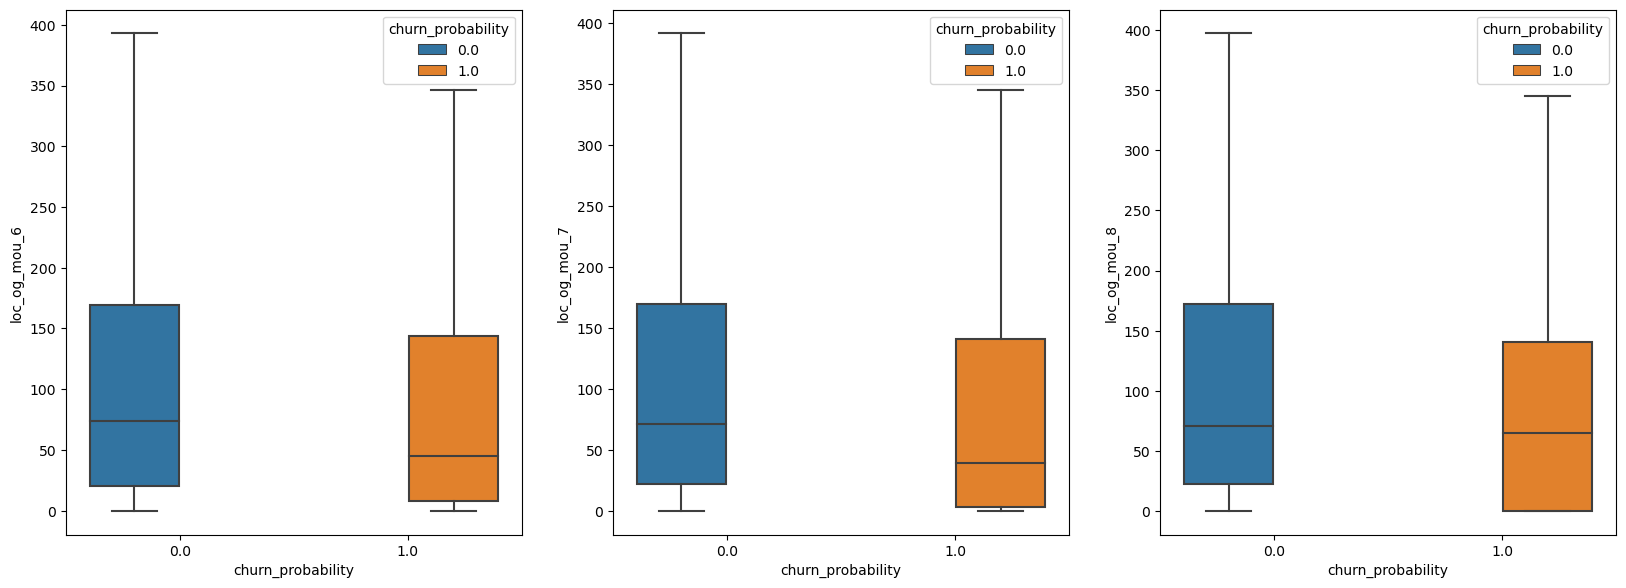

In [62]:
#Draw the box plot to understand the pattern of churn wrto total recharge amount
plot_sns_boxplot("loc_og_mou")

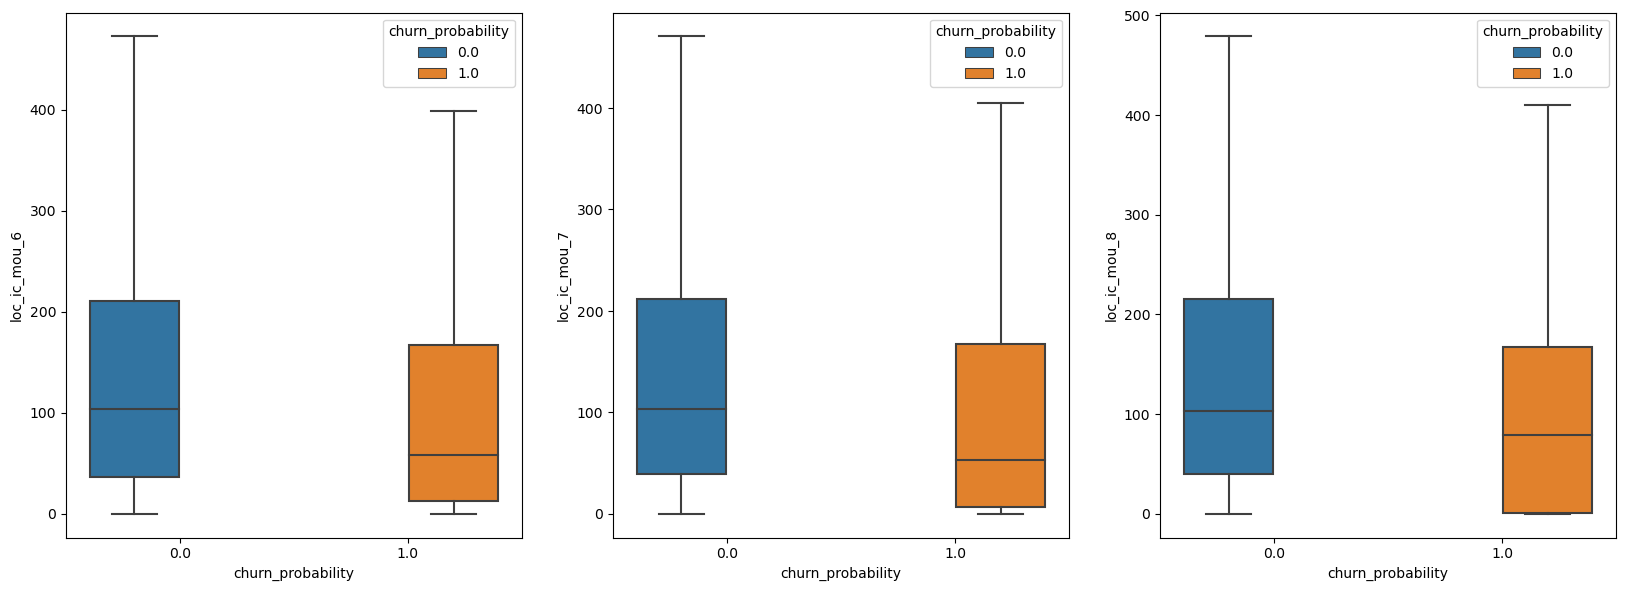

In [63]:
#Draw the box plot to understand the pattern of churn wrto total recharge amount
plot_sns_boxplot("loc_ic_mou")

- As per the Boxplot, there is a huge drop in maximum recharge amount, outgoing, incoming calls, for data in the 8th month (August) for churned customers as compared to other months. 


## 2.2. Bivariate Analysis

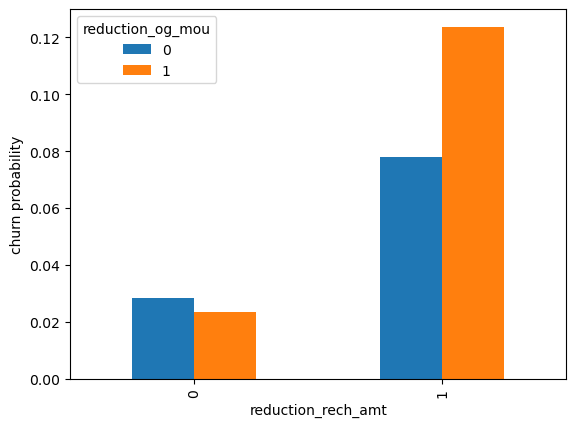

In [64]:
#Checking the relation of o/g mou, recharge amount, with churn
telecom_churn_data_filtered.pivot_table(values='churn_probability', index='reduction_rech_amt', columns='reduction_og_mou', aggfunc='mean').plot.bar()
plt.ylabel('churn probability')
plt.show()

- In the above case, the churn probability is higher for the customers for whom there is reduction in recharge amount, and reduction in outgoing calls.

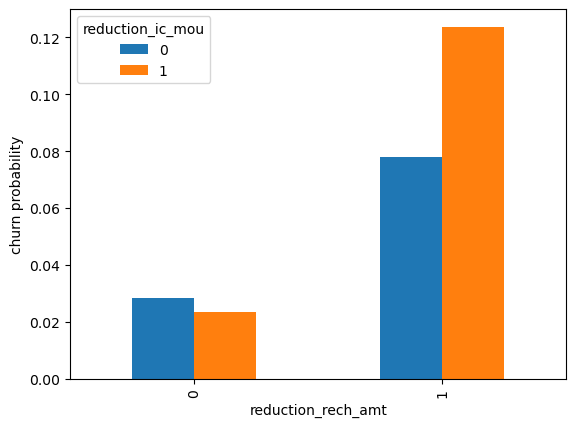

In [65]:
#Checking the relation of i/c mou, recharge amount, with churn
telecom_churn_data_filtered.pivot_table(values='churn_probability', index='reduction_rech_amt', columns='reduction_ic_mou', aggfunc='mean').plot.bar()
plt.ylabel('churn probability')
plt.show()

- In the above case, the churn probability is higher for the customers for whom there is reduction in recharge amount, and reduction in outgoing calls.

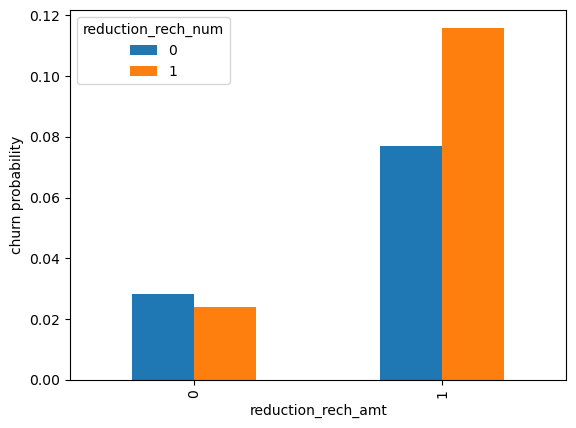

In [66]:
#Checking the relation of i/c mou, recharge amount, with churn
telecom_churn_data_filtered.pivot_table(values='churn_probability', index='reduction_rech_amt', columns='reduction_rech_num', aggfunc='mean').plot.bar()
plt.ylabel('churn probability')
plt.show()

- In the above case, the churn probability is higher for the customers for whom there is reduction in recharge amount, and reduction in number of recharges.

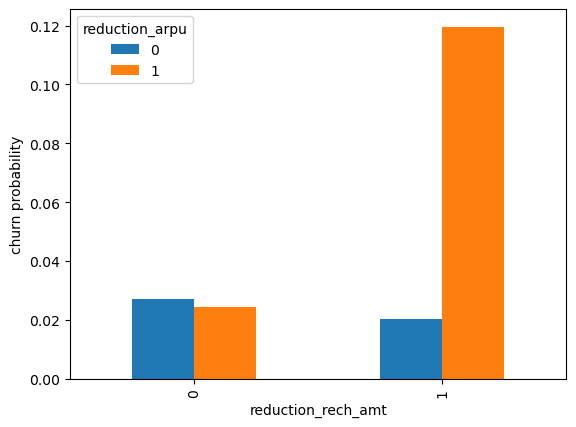

In [67]:
#Checking the relation of i/c mou, recharge amount, with churn
telecom_churn_data_filtered.pivot_table(values='churn_probability', index='reduction_rech_amt', columns='reduction_arpu', aggfunc='mean').plot.bar()
plt.ylabel('churn probability')
plt.show()

- In the above case, the churn probability is higher for the customers for whom there is reduction in recharge amount, and reduction in ARPU (Average Revenue Per User).

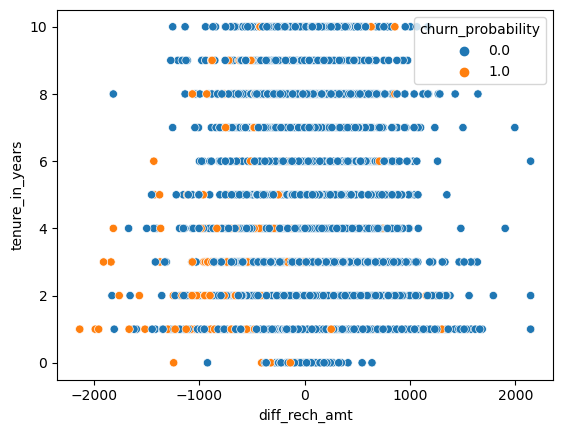

In [68]:
#Checking the relation of tenure, recharge amount, with churn
sns.scatterplot(x='diff_rech_amt',y='tenure_in_years', hue='churn_probability', data=telecom_churn_data_filtered)
plt.show()

- From graph, for the higher tenure,if the tenure, in combination with Recharge amount, is causing the churn across different tenures. But definitely for customer < 2 years there is higher churn, and difference in recharge amount is also more.

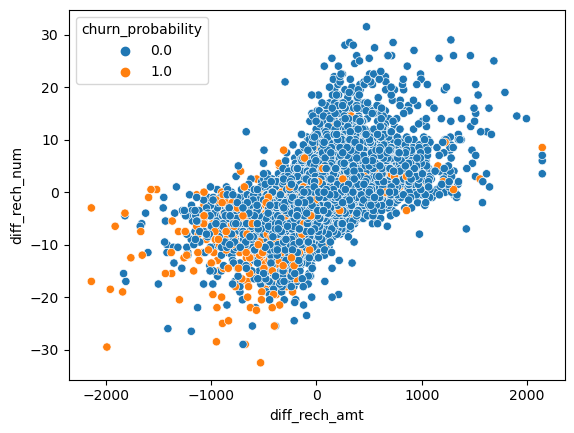

In [69]:
#Check the relation between difference in recharge amount, and the difference in recharge numbers with churn
sns.scatterplot(x='diff_rech_amt',y='diff_rech_num', hue='churn_probability', data=telecom_churn_data_filtered)
plt.show()

- From graph, the customers more recharge amount in August, as compared to previous 2 months average (>0), and more number of recharges [Towards top right], the churn is much lesser than the customers with lower recharge amount, lower number of recharges.

- Summary: 
  - From the observation of Univariate / Bivariate analysis:
    - in general the churn probability is higher in cases where there is reduction in ARPU, Recharge Amount (data, calls), Number of incoming, outgoing calls. 
    - For the customers who is there in network for longer timer (Typically > 5years), churn_probability is lesser compared to the customers, who are present for longer duration in network.
    - For customers with high recharge amount, and higher number of recharges has less churn probability.

In [70]:
# Drop newly added columns columns
telecom_churn_data_filtered = telecom_churn_data_filtered.drop(['tenure_range','tenure_in_years','diff_rech_amt','reduction_rech_amt',
                                                                'diff_rech_num','reduction_rech_num','diff_arpu','reduction_arpu',
                                                                'diff_og_mou','reduction_og_mou','diff_ic_mou','reduction_ic_mou'],axis=1)

# 3. Model Selection, Model Building

In [71]:
#Splitting the data
y = telecom_churn_data_filtered["churn_probability"]
X = telecom_churn_data_filtered.drop(["churn_probability"],axis=1)

In [72]:
# Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=100)
print("Dimension of X_train:", X_train.shape)
print("Dimension of X_test:", X_test.shape)

Dimension of X_train: (12250, 151)
Dimension of X_test: (5250, 151)


In [73]:
columns_scale = X_train.columns.to_list()

In [74]:
# Feature Scaling
scaler = StandardScaler()
X_train[columns_scale] = scaler.fit_transform(X_train[columns_scale])
X_test[columns_scale]  = scaler.transform(X_test[columns_scale])

In [75]:
# Store the features
features = telecom_churn_data_filtered.drop('churn_probability', axis=1).columns

## 3.1. Logistic Regression with sklearn (no PCA)

In [76]:
# Creating KFold object with 5 splits
num_folds = KFold(n_splits=5, shuffle=True, random_state=42)

params = {"C": [0.01, 0.1, 1, 10, 100]}

# Specifing score as accuracy
# added class_weight parameter  to take care of imbalance
logit_model_cv = GridSearchCV(estimator = LogisticRegression(class_weight="balanced"),
                        param_grid = params, 
                        scoring= 'accuracy', 
                        cv = num_folds, 
                        verbose = 1) 

In [77]:
# Fit the model
logit_model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]}, scoring='accuracy',
             verbose=1)

In [78]:
# Best score with best C
best_score = logit_model_cv.best_score_
best_c_value = logit_model_cv.best_params_['C']

In [79]:
print(" The highest test accuracy is {0} for C = {1}".format(best_score, best_c_value))

 The highest test accuracy is 0.8484897959183673 for C = 0.01


- Re-Modeling with Best C Score

In [80]:
# Re-model with best C value (0.01)
logit_model_best_c = LogisticRegression(C=best_c_value,class_weight="balanced")

In [81]:
# Fit the model
logit_model = logit_model_best_c.fit(X_train, y_train)

In [82]:
# Predictions on the train data set
y_train_pred = logit_model.predict(X_train)

In [83]:
logit_model.coef_

array([[-0.04912389,  0.24029561,  0.21442123,  0.02081833, -0.05145312,
         0.06084699,  0.06333366,  0.02571326, -0.04850398, -0.03393697,
         0.14172518, -0.00338469,  0.05225154, -0.03800033,  0.16114979,
         0.09086789,  0.0757982 , -0.06478454,  0.09704945, -0.02593337,
        -0.03966838, -0.0399559 , -0.08201776,  0.1552072 , -0.10041183,
        -0.02357432,  0.16173742,  0.07026611, -0.03782688,  0.02610888,
         0.16535806, -0.05676419, -0.10009269, -0.14791708,  0.15823929,
        -0.07327274, -0.03649749,  0.01670273, -0.19234042,  0.        ,
         0.        ,  0.        ,  0.05123302,  0.04098334,  0.04496497,
         0.04229163,  0.06324286,  0.05922027,  0.04241383,  0.04045635,
        -0.13409341, -0.02013158,  0.07889355,  0.62688073, -0.04189059,
         0.08196626, -0.19166425,  0.05415177, -0.01073652, -0.08916803,
         0.1093405 ,  0.05008243, -0.38070983, -0.11876278,  0.14062143,
        -0.14274626, -0.05294115,  0.06318699, -0.3

In [84]:
coefficients = logit_model.coef_[0]

In [85]:
feature_importance = pd.DataFrame({'Feature': features, 'Importance': coefficients})

In [86]:
feature_importance = feature_importance.sort_values('Importance',ascending=False)

In [87]:
#Top 10 features with Positive correlation
feature_importance.head(10)

,Feature,Importance
53,og_others_8,0.626881
1,arpu_7,0.240296
2,arpu_8,0.214421
125,arpu_3g_8,0.203458
72,std_ic_t2m_mou_6,0.171667
128,arpu_2g_8,0.170997
91,isd_ic_mou_7,0.170019
30,std_og_t2t_mou_6,0.165358
26,loc_og_t2c_mou_8,0.161737
14,roam_og_mou_8,0.161150


In [88]:
#Top 10 features with Negative correlation
feature_importance.tail(10)

,Feature,Importance
114,av_rech_amt_data_6,-0.216221
146,fb_user_8,-0.220325
101,total_rech_amt_8,-0.244937
110,total_rech_data_8,-0.260838
68,loc_ic_mou_8,-0.317783
147,aon,-0.322923
116,av_rech_amt_data_8,-0.372005
62,loc_ic_t2m_mou_8,-0.380710
89,spl_ic_mou_8,-0.394002
86,total_ic_mou_8,-0.420957


In [89]:
# Confusion matrix
confusion = confusion_matrix(y_train, y_train_pred)
print(confusion)

[[9752 1676]
 [ 139  683]]


In [90]:
#Calculate accuracy, sensitivity, specificity on train data
logit_train_metrics = calculate_metrics(y_train, y_train_pred)

In [91]:
# Accuracy on Training Set
print_metrics("Logistic Regression - Train ",logit_train_metrics)

Logistic Regression - Train  - Data Metrics:
#####################################################
Accuracy %: 85.18
Precision %: 28.95
Recall / Sensitivity %: 83.09
Specificity %: 85.33
#####################################################


In [92]:
# Prediction on the test set
y_test_pred = logit_model.predict(X_test)

In [93]:
# Confusion matrix
confusion = confusion_matrix(y_test, y_test_pred)
print(confusion)

[[4221  679]
 [  58  292]]


In [94]:
#Calculate accuracy, sensitivity, specificity on test data
logit_test_metrics = calculate_metrics(y_test, y_test_pred)

In [95]:
# Accuracy on Test Set
print_metrics("Logistic Regression - Test ",logit_test_metrics)

Logistic Regression - Test  - Data Metrics:
#####################################################
Accuracy %: 85.96
Precision %: 30.07
Recall / Sensitivity %: 83.43
Specificity %: 86.14
#####################################################


#### Summary of Observations with Logistic Regression(no (PCA):
    - Accuracy score is close to 85% for both train, test data.
    - For all the customers who actually churned the model is able to identify ~83% accurately. (Recall).
    - The precision is relatively low (~30%). So when the model predicted as churn, it was true about 30% of the time.
    - Specificity is around 85% with both train, test data. So the customers who have no churn is identifed ~85% correctly.
    
- Top Features:
    - Features with Positive Correlation:
        - 'og_others_8'
        - 'arpu_7'
        - 'arpu_8'
        - 'arpu_3g_8'
        - 'std_ic_t2m_mou_6'
        - 'arpu_2g_8'
        - 'isd_ic_mou_7'
        - 'std_og_t2t_mou_6'
        - 'loc_og_t2c_mou_8'
        - 'roam_og_mou_8'

    - Features with Negative Correlation:
        - 'av_rech_amt_data_6'
        - 'fb_user_8'
        - 'total_rech_amt_8'
        - 'total_rech_data_8'
        - 'loc_ic_mou_8'
        - 'aon'
        - 'av_rech_amt_data_8'
        - 'loc_ic_t2m_mou_8'
        - 'spl_ic_mou_8'
        - 'total_ic_mou_8'

## 3.2. Logistic Regression with PCA

In [96]:
from sklearn.decomposition import PCA
pca = PCA(random_state=42)

# applying PCA on train data
pca.fit(X_train)

PCA(random_state=42)

In [97]:
X_train_pca=pca.fit_transform(X_train)
print("Dimension of X_train_pca: ",X_train_pca.shape)

X_test_pca=pca.transform(X_test)

Dimension of X_train_pca:  (12250, 151)


In [98]:
X_train_pca

array([[ 3.59754826e+00, -7.49294138e-01, -2.54563120e+00, ...,
         2.57220823e-17, -8.78839961e-17, -3.17935046e-16],
       [-3.81902927e+00, -1.87991605e+00, -1.35074913e+00, ...,
        -7.00231695e-17, -1.47092720e-16,  1.46323132e-16],
       [-1.53076299e+00,  1.41999400e+00, -6.59122723e-01, ...,
         3.51059287e-17, -4.17990673e-16, -3.53388979e-16],
       ...,
       [-1.93433854e+00,  9.40590784e-01,  1.68840298e+00, ...,
         6.40600243e-18,  8.41110750e-19, -3.07690010e-17],
       [-5.08608263e+00, -6.44030351e-01, -2.02660137e-01, ...,
        -2.79451540e-18,  2.54310957e-18, -5.58750879e-18],
       [ 3.73929470e+00, -1.19317214e+00, -4.27878363e+00, ...,
         7.89540368e-17, -3.13741409e-17, -1.02712385e-17]])

In [99]:
#Viewing the PCA components
pca.components_

array([[ 1.66458637e-01,  1.71271564e-01,  1.64168847e-01, ...,
         5.89354387e-02,  5.90572573e-02,  5.68077936e-02],
       [ 1.56033031e-02,  1.08883466e-02,  6.87041794e-03, ...,
         1.31956093e-01,  1.42619649e-01,  1.41288409e-01],
       [ 5.77537626e-02,  7.86948396e-02,  6.74008207e-02, ...,
         2.73532246e-02,  3.12255511e-02,  3.00300961e-02],
       ...,
       [ 0.00000000e+00, -2.07975990e-18,  2.06545023e-16, ...,
        -1.47890940e-16,  3.34602814e-17,  7.04070377e-18],
       [ 0.00000000e+00, -2.41295699e-17,  8.16093852e-17, ...,
         1.35321109e-16, -9.97310449e-17, -1.75161999e-17],
       [-0.00000000e+00, -2.17714320e-17,  1.33237106e-16, ...,
        -6.13184450e-17, -5.57639078e-17,  1.85733047e-17]])

In [100]:
pca.explained_variance_ratio_

array([1.50591664e-01, 7.87593498e-02, 6.72560814e-02, 5.19283855e-02,
       3.84920997e-02, 3.30371760e-02, 2.64199577e-02, 2.54176422e-02,
       2.36594870e-02, 2.28309864e-02, 2.22782065e-02, 2.05401513e-02,
       1.86567387e-02, 1.71506788e-02, 1.52777224e-02, 1.48102492e-02,
       1.45034460e-02, 1.33581543e-02, 1.29199472e-02, 1.24377110e-02,
       1.12388130e-02, 1.02774459e-02, 1.01129082e-02, 9.02753570e-03,
       8.96640399e-03, 8.57483277e-03, 8.34133521e-03, 8.19885547e-03,
       8.06377123e-03, 7.75508359e-03, 7.68047485e-03, 7.54986296e-03,
       7.26193598e-03, 7.11369020e-03, 6.73684428e-03, 6.37314120e-03,
       5.91858064e-03, 5.82638099e-03, 5.68613656e-03, 5.63920101e-03,
       5.40563871e-03, 5.29012242e-03, 5.11952847e-03, 5.03710155e-03,
       4.65437727e-03, 4.45636044e-03, 4.44024463e-03, 4.23049124e-03,
       4.03812286e-03, 3.96084737e-03, 3.82804958e-03, 3.75384415e-03,
       3.63439219e-03, 3.56669251e-03, 3.49559839e-03, 3.33103435e-03,
      

- ScreePlot to check the number of PC's which can explain most of the variance

In [101]:
var_cum = np.cumsum(pca.explained_variance_ratio_)

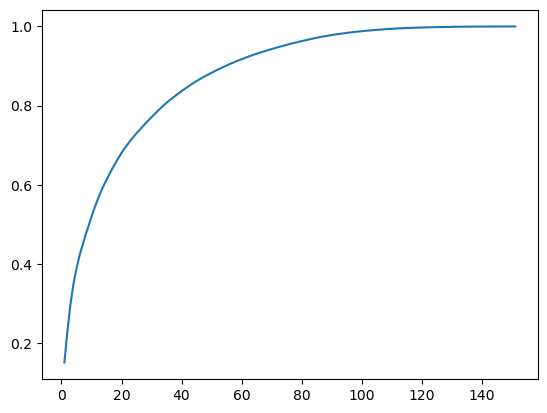

In [102]:
#ScreePlot
plt.plot(range(1,len(var_cum)+1), var_cum)

- From the above plot, 60+ features explains >90% of variance,and around 80+ features explains ~95% pf variance.

In [103]:
# Instantiate PCA with 80 components which expains ~95% of variance
incr_pca = IncrementalPCA(n_components=80)

In [104]:
X_train_pca = incr_pca.fit_transform(X_train)
X_test_pca = incr_pca.transform(X_test)

In [105]:
# Creating KFold object with 5 splits
num_folds = KFold(n_splits=5, shuffle=True, random_state=42)

params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

# Specifing score as accuracy
# added class_weight parameter  to take care of imbalance
logit_pca_model_cv = GridSearchCV(estimator = LogisticRegression(class_weight="balanced"),
                        param_grid = params, 
                        scoring= 'accuracy', 
                        cv = num_folds, 
                        verbose = 1) 

In [106]:
logit_pca_model_cv.fit(X_train_pca, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             scoring='accuracy', verbose=1)

In [107]:
best_score = logit_pca_model_cv.best_score_
best_c_score = logit_pca_model_cv.best_params_['C']

In [108]:
logit_pca_best_cv = LogisticRegression(C=best_c_score,class_weight="balanced")

In [109]:
# Fit the model
logit_pca_model = logit_pca_best_cv.fit(X_train_pca, y_train)

In [110]:
#predict
y_train_pred = logit_pca_model.predict(X_train_pca)

In [111]:
# Confusion matrix
confusion = confusion_matrix(y_train, y_train_pred)
print(confusion)

[[9707 1721]
 [ 149  673]]


In [112]:
#Calculate accuracy, sensitivity, specificity on test data
logit_pca_train_metrics = calculate_metrics(y_train, y_train_pred)

In [113]:
# Accuracy on Train Set
print_metrics("Logistic Regression With PCA - Train ",logit_pca_train_metrics)

Logistic Regression With PCA - Train  - Data Metrics:
#####################################################
Accuracy %: 84.73
Precision %: 28.11
Recall / Sensitivity %: 81.87
Specificity %: 84.94
#####################################################


In [114]:
# Prediction on the test set
y_test_pred = logit_pca_model.predict(X_test_pca)

In [115]:
# Confusion matrix
confusion = confusion_matrix(y_test, y_test_pred)
print(confusion)

[[4223  677]
 [  58  292]]


In [116]:
#Calculate accuracy, sensitivity, specificity on test data
logit_pca_test_metrics = calculate_metrics(y_test, y_test_pred)

In [117]:
# Accuracy on Test Set
print_metrics("Logistic Regression With PCA - Test ",logit_pca_test_metrics)

Logistic Regression With PCA - Test  - Data Metrics:
#####################################################
Accuracy %: 86.0
Precision %: 30.13
Recall / Sensitivity %: 83.43
Specificity %: 86.18
#####################################################


#### Summary of Logistic Regression with PCA:
    - Accuracy score is close to 85% for both train, test data.
    - The recall of the model is around 30%. So for all the customers who actually churned the model is able to identify ~83% accurately. 
    - The precision is relatively low (~30%). So when the model predicted as churn, it was true about 30% of the time.
    -  Specificity is around 84% on train data, and 86% on test data.  So the customers who have no churn is identifed ~84-86% correctly.

## 3.4. DecisionTree with hyperparameter tuning

In [118]:
params = {
    "max_depth":[2,3,5,10,20],
    "min_samples_leaf":[5,10,20,50,100],
    "min_samples_split":[5,10,20,50],
    "criterion":['gini','entropy']
}

In [119]:
#DecisionTree Classifier with class weight
# In this case weight is chosen as 20% for non-churn and 80% for churn to address imbalance problems.
dt = DecisionTreeClassifier(random_state=42,class_weight={0:0.2, 1: 0.8})

In [120]:
#As the data is balanced use "accuracy" as measure
grid_search_dt = GridSearchCV(estimator=dt,
             param_grid=params,
             cv=4,n_jobs=-1,verbose=1,
             scoring="accuracy")

In [121]:
%%time
grid_search_dt.fit(X_train,y_train)

Fitting 4 folds for each of 200 candidates, totalling 800 fits
Wall time: 2min 50s


GridSearchCV(cv=4,
             estimator=DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8},
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'min_samples_split': [5, 10, 20, 50]},
             scoring='accuracy', verbose=1)

In [122]:
cv_df = pd.DataFrame(grid_search_dt.cv_results_)

In [123]:
dt_best = grid_search_dt.best_estimator_
dt_best

DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8}, max_depth=3,
                       min_samples_leaf=5, min_samples_split=5,
                       random_state=42)

In [124]:
 y_train_pred = dt_best.predict(X_train)

In [125]:
confusion = confusion_matrix(y_train,y_train_pred)
confusion

array([[11057,   371],
       [  346,   476]], dtype=int64)

In [126]:
#Calculate accuracy, sensitivity, specificity on train data
dt_train_metrics = calculate_metrics(y_train, y_train_pred)

In [127]:
# Accuracy on Train Set
print_metrics("Decision Train - Test ",dt_train_metrics)

Decision Train - Test  - Data Metrics:
#####################################################
Accuracy %: 94.15
Precision %: 56.2
Recall / Sensitivity %: 57.91
Specificity %: 96.75
#####################################################


In [128]:
y_test_pred = dt_best.predict(X_test)

In [129]:
#Calculate accuracy, sensitivity, specificity on test data
dt_test_metrics = calculate_metrics(y_test, y_test_pred)

In [130]:
# Accuracy on Test Set
print_metrics("Decision Tree - Test ",dt_test_metrics)

Decision Tree - Test  - Data Metrics:
#####################################################
Accuracy %: 94.72
Precision %: 60.58
Recall / Sensitivity %: 59.71
Specificity %: 97.22
#####################################################


- Accuracy is ~95% in both train, test set using a DecisionTreeClassifier. But the Recall value are very low (around 60%) using decision trees.

In [131]:
dt_best.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00461751, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.0139786 , 0.04682553, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [132]:
dt_best_imp = pd.DataFrame({"VariableName":features,"Importance":dt_best.feature_importances_})
dt_best_imp.sort_values(by="Importance",ascending=False)

,VariableName,Importance
86,total_ic_mou_8,0.801254
116,av_rech_amt_data_8,0.070609
146,fb_user_8,0.054217
68,loc_ic_mou_8,0.046826
67,loc_ic_mou_7,0.013979
...,...,...
49,spl_og_mou_7,0.000000
50,spl_og_mou_8,0.000000
51,og_others_6,0.000000
52,og_others_7,0.000000


#### Summary of Decision Tree Model:
    - Accuracy score is improved compared to Logistic Regression Models. It is close to 95% in both test, train data. 
    - The recall of the model is reduced in case of decision tree, and it is around 60% . So for all the customers who actually churned the model is able to identify only ~60% accurately. 
    - The precision with decision tree model is improved to ~60%.So when the model predicted as churn, it was true about 60% of the time.
    - Specificity is around 96% on train and test data.  So the customers who have no churn is identifed ~96% correctly.
    
    -Important features from DecisionTree Model: 
      - `total_ic_mou_8` [Total Incoming calls of 8th Month (August)]
      - `fb_user_8` [FB Services availed by users in 8th Month(August)]
      - `av_rech_amt_data_8` [Average data recharge amount for 8th Month(August)]
      - `loc_ic_mou_8` [Local incoming calls for 8th Month(August)]
      - `total_og_mou_8` [Total outgoing calls for 8th Month(August)]


## 3.5. RandomForest with hyperparameter Tuning

In [133]:
#Initiate RF with class weight,
# in this case weight is chosen as 20% for no churn, and 80% for churn case
classifier_rf = RandomForestClassifier(random_state=42,n_jobs=-1,class_weight={0:0.2, 1: 0.8},oob_score=True)

In [134]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [1, 2, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'max_features': [2,3,4,5],
    'n_estimators': [10, 30, 50, 100, 200]
}

In [135]:
# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator=classifier_rf, param_grid=params,
                          cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [136]:
%%time
grid_search_rf.fit(X_train,y_train)

Fitting 4 folds for each of 500 candidates, totalling 2000 fits
Wall time: 13min 6s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(class_weight={0: 0.2, 1: 0.8},
                                              n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 5, 10, 20],
                         'max_features': [2, 3, 4, 5],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'n_estimators': [10, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [137]:
grid_search_rf.best_score_

0.9503671856824238

In [138]:
rf_best = grid_search_rf.best_estimator_
rf_best

RandomForestClassifier(class_weight={0: 0.2, 1: 0.8}, max_depth=20,
                       max_features=5, min_samples_leaf=5, n_estimators=50,
                       n_jobs=-1, oob_score=True, random_state=42)

In [139]:
 y_train_pred = rf_best.predict(X_train)

In [140]:
confusion = confusion_matrix(y_train,y_train_pred)
confusion

array([[11268,   160],
       [  184,   638]], dtype=int64)

In [141]:
#Calculate accuracy, sensitivity, specificity on train data
rf_train_metrics = calculate_metrics(y_train, y_train_pred)

In [142]:
# Accuracy on Train Set
print_metrics("RandomForest - Train ",rf_train_metrics)

RandomForest - Train  - Data Metrics:
#####################################################
Accuracy %: 97.19
Precision %: 79.95
Recall / Sensitivity %: 77.62
Specificity %: 98.6
#####################################################


In [143]:
y_test_pred = rf_best.predict(X_test)

In [144]:
#Calculate accuracy, sensitivity, specificity on test data
rf_test_metrics = calculate_metrics(y_test, y_test_pred)

In [145]:
# Accuracy on Test Set
print_metrics("RandomForest - Test ",rf_test_metrics)

RandomForest - Test  - Data Metrics:
#####################################################
Accuracy %: 95.16
Precision %: 67.65
Recall / Sensitivity %: 52.57
Specificity %: 98.2
#####################################################


In [146]:
# OOB Score
rf_best.oob_score_

0.9485714285714286

In [147]:
#Important Features
rf_best.feature_importances_

array([0.00542121, 0.00706488, 0.04400321, 0.00405769, 0.00414196,
       0.01593381, 0.0062203 , 0.00489116, 0.00669392, 0.00457033,
       0.00494641, 0.04266854, 0.00280241, 0.00742025, 0.02428268,
       0.0037402 , 0.00614872, 0.00646734, 0.00404566, 0.00514428,
       0.0067098 , 0.00127519, 0.00216785, 0.00492086, 0.00168526,
       0.00223577, 0.00854453, 0.00403532, 0.00416481, 0.009821  ,
       0.00431865, 0.00475763, 0.01307484, 0.00288774, 0.00400889,
       0.01537427, 0.00080922, 0.00086622, 0.0119078 , 0.        ,
       0.        , 0.        , 0.00490707, 0.00286288, 0.00846197,
       0.00152542, 0.00628353, 0.01208898, 0.00304277, 0.00399906,
       0.00909751, 0.00184344, 0.00044304, 0.02120842, 0.00583967,
       0.00886976, 0.02540363, 0.004238  , 0.0041784 , 0.01060911,
       0.00528991, 0.00685294, 0.0172363 , 0.00345765, 0.00398017,
       0.00502593, 0.00518234, 0.00855764, 0.01643812, 0.00257297,
       0.00267781, 0.003594  , 0.0029217 , 0.00294862, 0.00749

In [151]:
#Important features of RF
rf_best_imp = pd.DataFrame({
    "VariableName": features,
    "Importance": rf_best.feature_importances_
})

In [152]:
rf_best_imp = rf_best_imp.sort_values(by="Importance", ascending=False).head(10)
rf_best_imp.head(10)

,VariableName,Importance
101,total_rech_amt_8,0.046878
2,arpu_8,0.044003
11,roam_ic_mou_8,0.042669
86,total_ic_mou_8,0.040230
104,max_rech_amt_8,0.031071
56,total_og_mou_8,0.025404
14,roam_og_mou_8,0.024283
119,vol_2g_mb_8,0.022610
53,og_others_8,0.021208
107,last_day_rch_amt_8,0.017482


#### Summary of Random Forest Model:
    - Accuracy score is improved compared to Logistic Regression Models. It is close to 95% in both test, train data. 
    - The recall of the model is reduced in case of RF. With trainset it looks the recall is around80%, but with test set it is dropped around. So for all the customers who actually churned the model is able to identify only ~60% accurately. 
    - The precision with decision tree model is improved to ~80% with train data set, and 70% with test data.So when the model predicted as churn, it was true about 70-80% of the time.
    - Specificity is around 98% on train and test data.  So the customers who have no churn is identifed ~98% correctly.
    - OOB Score is close to 95%, which indicates % of correctly predicted samples.
    
    -Important features from RandomForest Model: 
        Top 10 features of the RF model. Most of the features are related to to August Month. 
        - `total_rech_amt_8`
        - `arpu_8`
        - `roam_ic_mou_8`
        - `total_ic_mou_8`
        - `max_rech_amt_8`
        - 'total_og_mou_8'
        - 'roam_og_mou_8'
        - 'vol_2g_mb_8'
        - 'last_day_rch_amt_8'
        

### Summarizing the performance of all models:

In [155]:

stat_summary = pd.DataFrame(index=["Accuracy-Train","Precision-Train","Recall-Train","specificity-Train",
                                   "Accuracy-Test","Precision-Test","Recall-Test","specificity-Test"],
                       columns = ['LogisticRegression', 'LogisticRegressionWithPCA', 'DecisionTree','RandomForest'])
stat_summary['LogisticRegression'] = [logit_train_metrics[0],logit_train_metrics[1],logit_train_metrics[2],logit_train_metrics[3],
                                      logit_test_metrics[0],logit_test_metrics[1],logit_test_metrics[2],logit_test_metrics[3]]
stat_summary['LogisticRegressionWithPCA'] = [logit_pca_train_metrics[0],logit_pca_train_metrics[1],logit_pca_train_metrics[2],logit_pca_train_metrics[3],
                                             logit_pca_test_metrics[0],logit_pca_test_metrics[1],logit_pca_test_metrics[2],logit_pca_test_metrics[3]]
stat_summary['DecisionTree'] = [dt_train_metrics[0],dt_train_metrics[1],dt_train_metrics[2],dt_train_metrics[3],
                                dt_test_metrics[0],dt_test_metrics[1],dt_test_metrics[2],dt_test_metrics[3]]
stat_summary['RandomForest'] = [rf_train_metrics[0],rf_train_metrics[1],rf_train_metrics[2],rf_train_metrics[3],
                                rf_test_metrics[0],rf_test_metrics[1],rf_test_metrics[2],rf_test_metrics[3]]
stat_summary

,LogisticRegression,LogisticRegressionWithPCA,DecisionTree,RandomForest
Accuracy-Train,0.851837,0.847347,0.941469,0.971918
Precision-Train,0.289529,0.281119,0.561983,0.799499
Recall-Train,0.830900,0.818735,0.579075,0.776156
specificity-Train,0.853343,0.849405,0.967536,0.985999
Accuracy-Test,0.859619,0.860000,0.947238,0.951619
Precision-Test,0.300721,0.301342,0.605797,0.676471
Recall-Test,0.834286,0.834286,0.597143,0.525714
specificity-Test,0.861429,0.861837,0.972245,0.982041


#### Summary:
    Based on above metrics:
        - The LogisticRegression with / without PCA has  better  Accuary (~85%), Recall(around 82-83%)
        - Tree Models (DecisionTree, RF) has much better accuracy (~95%) with train, and test set.Precision is ~80% on train set for RF. But on testset is around 67%. With Decision Trees, precision is around 60%. Recall on RF train set is close to 80%, but om test set it is around 52%. With decision trees, the Recall is around 60%.
 

#### Recommended Model:
        - As  the current problem is to identify whether customers are churned or not, so the focus is more on higher sensitivity / Recall. The main goal is to retain the high value customers, who have the possiblity to churn. Even if we consider few non churn customers as churn, and provide them some additional offerings for retaining them, it should be fine. Hence, the sensitivity / recall score is important.


# 4. Final Model Evaluation with Kaggle Test Data

- Note: Selected Model to validate Testdata is  LogisticRegression with PCA

In [192]:
# Reading the training dataset
telecom_churn_data_test = pd.read_csv("test.csv")
#Copying the original data
telecom_churn_data_test.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00,0.0
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00,0.0
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84,0.0
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00,0.0
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00,0.0


In [193]:
telecom_churn_data_test.shape

(30000, 172)

In [194]:
#Selecting the same columns as the original data
telecom_churn_data_test_filtered = telecom_churn_data_test.loc[:,telecom_churn_data_test.columns.isin(features)] 

In [195]:
#Re-check shape after filtering columns
telecom_churn_data_test_filtered.shape

(30000, 151)

- Creating `churn_probability` Variable in TestData (as it is not being provided).

In [196]:
X_test_kaggle = telecom_churn_data_test_filtered
y_test_kaggle = pd.DataFrame(columns=['churn_probability'])

In [197]:
# create churn variable: 
# Criteria - Customers who have not used either calls or internet in the month of August are customers who have churned
# 0 - not churn, 1 - churn
# calculate total incoming and outgoing minutes of usage
X_test_kaggle['total_calls_mou_8'] = X_test_kaggle['total_ic_mou_8'] + X_test_kaggle['total_og_mou_8']

# calculate 2g and 3g data consumption
X_test_kaggle['total_internet_mb_8'] = X_test_kaggle['vol_2g_mb_8'] + X_test_kaggle['vol_3g_mb_8']

y_test_kaggle['churn_probability'] = X_test_kaggle.apply(lambda row: 1 if (row['total_calls_mou_8'] ==0 and row['total_internet_mb_8'] == 0) else 0, axis=1)

In [198]:
#Drop the above 2 variables added, as churn probability column is already updated.
X_test_kaggle = X_test_kaggle.drop(['total_calls_mou_8','total_internet_mb_8'],axis=1)

In [199]:
#Check Missing value percentage
percent_missing = get_missing_value_percentage(X_test_kaggle)
percent_missing.head(30)

,missing_percentage
fb_user_6,74.717
av_rech_amt_data_6,74.717
arpu_3g_6,74.717
arpu_2g_6,74.717
total_rech_data_6,74.717
night_pck_user_6,74.717
max_rech_data_6,74.717
fb_user_7,74.313
night_pck_user_7,74.313
total_rech_data_7,74.313


In [200]:
#Data Transformations
X_test_kaggle[categorical_na_cols] = X_test_kaggle[categorical_na_cols].apply(lambda x: x.fillna(-1))
X_test_kaggle[numerical_na_cols] = X_test_kaggle[numerical_na_cols].apply(lambda x: x.fillna(0))

In [201]:
#Re-Check Missing value percentage
percent_missing = get_missing_value_percentage(X_test_kaggle)
percent_missing.head(30)

,missing_percentage
loc_ic_t2t_mou_8,5.583
loc_og_t2m_mou_8,5.583
loc_og_t2c_mou_8,5.583
std_ic_mou_8,5.583
loc_og_mou_8,5.583
std_og_t2t_mou_8,5.583
std_og_t2m_mou_8,5.583
std_ic_t2o_mou_8,5.583
std_og_t2f_mou_8,5.583
std_og_t2c_mou_8,5.583


In [202]:
#using simple imputer for imputation
imputer = SimpleImputer(missing_values = np.nan,strategy ='mean')
imputer = imputer.fit(X_test_kaggle)
#Impute the data    
imputed_data = imputer.transform(X_test_kaggle)

X_test_kaggle = pd.DataFrame(imputed_data, columns=X_test_kaggle.columns)
X_test_kaggle.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,...,0.0,0.0,0.0,-1.0,-1.0,-1.0,1692.0,0.00,0.00,0.00
1,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,...,0.0,0.0,0.0,-1.0,-1.0,-1.0,2533.0,0.00,0.00,0.00
2,329.844,434.884,746.239,7.54,7.86,8.40,16.98,45.81,45.04,22.81,...,0.0,0.0,0.0,-1.0,-1.0,-1.0,277.0,525.61,758.41,241.84
3,43.550,171.390,24.400,5.31,2.16,0.00,40.04,205.01,24.01,0.00,...,0.0,0.0,0.0,-1.0,-1.0,-1.0,1244.0,0.00,0.00,0.00
4,306.854,406.289,413.329,450.93,609.03,700.68,60.94,23.84,74.16,0.00,...,0.0,0.0,0.0,-1.0,-1.0,-1.0,462.0,0.00,0.00,0.00


In [203]:
#Re-Check Missing value percentage
percent_missing = get_missing_value_percentage(X_test_kaggle)
percent_missing.head(30)

,missing_percentage
arpu_6,0.0
ic_others_8,0.0
total_rech_num_7,0.0
total_rech_num_8,0.0
total_rech_amt_6,0.0
total_rech_amt_7,0.0
total_rech_amt_8,0.0
max_rech_amt_6,0.0
max_rech_amt_7,0.0
max_rech_amt_8,0.0


In [204]:
# Feature Scaling
X_test_kaggle[columns_scale] = scaler.transform(X_test_kaggle[columns_scale])

In [205]:
X_test_kaggle.describe()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-0.281493,-0.303673,-0.310413,0.113745,0.099613,0.114456,0.031859,0.035911,0.033234,0.045614,...,-0.207045,-0.208668,-0.196419,-1.218181,-1.286963,-1.269302,0.026788,-0.423110,-0.400285,-0.380927
std,0.955357,0.954077,0.947491,1.364219,1.319618,1.352854,1.201483,1.257970,1.243654,2.970535,...,0.776659,0.797428,0.781010,0.999795,1.031886,1.031145,1.006227,0.645630,0.670894,0.633337
min,-1.701915,-7.073612,-1.548931,-0.511638,-0.492096,-0.499312,-0.725123,-0.721042,-0.719701,-0.269014,...,-0.309424,-0.309994,-0.301397,-1.791215,-1.884367,-1.875965,-1.061095,-0.590518,-0.566226,-0.535059
25%,-0.857747,-0.870000,-0.878334,-0.473434,-0.459522,-0.464684,-0.584532,-0.590686,-0.586687,-0.269014,...,-0.309424,-0.309994,-0.301397,-1.791215,-1.884367,-1.875965,-0.761357,-0.590518,-0.566226,-0.535059
50%,-0.537877,-0.562202,-0.566284,-0.327465,-0.331446,-0.324165,-0.328351,-0.342704,-0.327244,-0.269014,...,-0.309424,-0.309994,-0.301397,-1.791215,-1.884367,-1.875965,-0.355769,-0.590518,-0.566226,-0.535059
75%,-0.010203,-0.050115,-0.055108,0.113745,0.099613,0.114456,0.126236,0.113370,0.098696,-0.269014,...,-0.309424,-0.309994,-0.301397,-0.604563,-0.664760,-0.661668,0.631479,-0.590518,-0.566226,-0.535059
max,32.131915,37.908268,38.078793,32.734098,32.442228,30.503668,26.199936,36.463162,51.152930,415.712623,...,38.709793,45.175912,38.011800,0.582089,0.554846,0.552629,3.148855,14.246213,18.675749,16.487516


In [207]:
#Applying Incremental PCA
X_test_pca = incr_pca.transform(X_test_kaggle)

In [209]:
#predict
y_test_Kaggle_pred = logit_pca_model.predict(X_test_pca)

In [210]:
# Confusion matrix
confusion = confusion_matrix(y_test_kaggle, y_test_Kaggle_pred)
print(confusion)

[[15348 12234]
 [    3  2415]]


In [211]:
#Calculate accuracy, sensitivity, specificity on test data
logit_pca_kaggle_test_metrics = calculate_metrics(y_test, y_test_pred)

In [212]:
y_test_Kaggle_pred

array([0., 1., 1., ..., 1., 1., 0.])

In [186]:
type(y_test_Kaggle_pred)

numpy.ndarray

In [223]:
#Updating the sample solution csv of kaggle
telecom_churn_sample_data = pd.read_csv("sample.csv")
telecom_churn_sample_data.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [229]:
telecom_churn_sample_data['churn_probability'] = y_test_Kaggle_pred
#Copying the original data
telecom_churn_submit_data = telecom_churn_sample_data
#telecom_churn_sample_data_copy['churn_probability'] = y_test_Kaggle_pred
telecom_churn_submit_data.to_csv('submission.csv',index=False)

In [230]:
telecom_churn_submit_data.head()

,id,churn_probability
0,69999,0.0
1,70000,1.0
2,70001,1.0
3,70002,0.0
4,70003,1.0


In [226]:
# Accuracy on Test Set
print_metrics("Logistic Regression With PCA - Kaggle Test ",logit_pca_kaggle_test_metrics)

Logistic Regression With PCA - Kaggle Test  - Data Metrics:
#####################################################
Accuracy %: 95.16
Precision %: 67.65
Recall / Sensitivity %: 52.57
Specificity %: 98.2
#####################################################


# 5. Business Insights & Recommendations:

- Below are few top variables selected in the logistic regression model.

In [227]:
#Features having positive correlation with churn_probability
feature_importance.head(10)

,Feature,Importance
53,og_others_8,0.626881
1,arpu_7,0.240296
2,arpu_8,0.214421
125,arpu_3g_8,0.203458
72,std_ic_t2m_mou_6,0.171667
128,arpu_2g_8,0.170997
91,isd_ic_mou_7,0.170019
30,std_og_t2t_mou_6,0.165358
26,loc_og_t2c_mou_8,0.161737
14,roam_og_mou_8,0.161150


In [228]:
#Features having negative correlation with churn_probability
feature_importance.tail(10)

,Feature,Importance
114,av_rech_amt_data_6,-0.216221
146,fb_user_8,-0.220325
101,total_rech_amt_8,-0.244937
110,total_rech_data_8,-0.260838
68,loc_ic_mou_8,-0.317783
147,aon,-0.322923
116,av_rech_amt_data_8,-0.372005
62,loc_ic_t2m_mou_8,-0.380710
89,spl_ic_mou_8,-0.394002
86,total_ic_mou_8,-0.420957


- Most of the top variables are negatively correlated with the churn probability.
#### Below are the customers with Possibility of Churn:
    - who has less incoming call minutes in the month of August(local calls from other operator, special calls) in the month of August(loc_ic_t2m_mou_8, spl_ic_mou_8 has negative coefficients). 
    - Whose average rech amount for calls, and data is decreasing in the month of august (av_rech_amt_data_8)
    - Customers whose tenure (aon) is smaller, has higher probability of churn.
    - whose local outgoing minutes are less in the month of August (loc_og_mou_8,std_og_mou_8)
    - ARPU in the month of July, August  has a positive coefficeint. This means customers, with Higher Avg Revenue for 3G data have more probability to churn. 
    - Customers whose roaming ougoign minutes are more in the month of August, has more probability of churn.

#### Recommendatations: 
    - Telecom Company can focus more on the  rates of data, and Roaming. Company can provide more offers on data, roaming services.
    - Telecom Company can provide more on the customers with smaller tenure (0-2 years), and provide more offers to avoid possibility of churn.
    - Company needs to check on local OG call rates.

